# LoRaDongle Data Analysis Notebook

## Imports
Starts with importing the relevant packages

In [51]:
import csv, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Global Variables
The variables that will be used in the notebook:
* List of the directories
* Data stored in a dictionary of lists, with the directories being keys and the list having csvs in a dataframe

In [52]:
data = {}
directories = ['menzies_tests/','parkade_tests/', 'outdoor_cbd/', 'outdoor_forest/', 'outdoor_los/']
info = {}

# Reading Information CSVs
(Will likely be more important for actual analysis)

In [53]:
#for i, directory in enumerate(directories):
#    csv_name = directory + 'tests_info.csv'
#    info[directory] = pd.read_csv(csv_name)

info[directories[0]] = pd.read_csv('menzies_tests/tests_info.csv')
#print(info)

# Reading Data CSVs
(probably not useful)

In [54]:
for i, directory in enumerate(directories):
    count = 0
    data[directory] = []
    for path in os.listdir(directory):
        # check if current path is a file
        if os.path.isfile(os.path.join(directory, path)):
            count += 1
        
    print(f'File count in {directory}:  {count}')

    #reading every csv, might need to keep track of test_number? or read csv indiviaidually!
    for j in range(1,count):
        csv_name = directories[i] + 'Test_' + str(j) + '.csv'
        #print(csv_name)
        data[directory].append(pd.read_csv(csv_name))
        


File count in menzies_tests/:  14
File count in parkade_tests/:  0
File count in outdoor_cbd/:  0
File count in outdoor_forest/:  0
File count in outdoor_los/:  0


In [85]:
# Just a test, not useful in final draft!

for csv in data[directories[0]]:
    #print (csv.to_string())
    pass
menzies_df_1 = data[directories[0]][12]

## Plan of action
With CSVs read, the goal is to print graphs for all the tests performed. Graphs should tell me things such as:
* Percentage of successful messages
* Average transmit latency
* Average Round Time Latencies
* Graph of SNRs and RSSIs


### New plan for reading and handling csvs
It seems like it would be easier to use tests_info.csv to iterate through CSVs in that folder and then extract the information you need from each csv. As opposed to reading all of them at once and struggling through.

## Latencies
Probably best to show it as a table. Should show max/min and average latency for each configuration! Therefore, iterate through csvs and get necessary data!

Basically create a new dataframe of read CSVs

### With New Plan
For every line in the read csv file (which is a test descriptor), read that test csv and extract the average, min and max latency. Store it in a new location

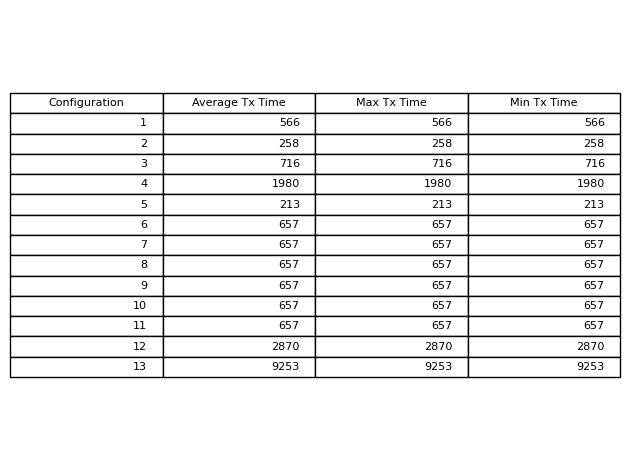

In [86]:
latency_columns = ['Configuration', "Average Tx Time", "Max Tx Time", "Min Tx Time"]  #for now, configuration corresponds to test number, for latency testing there should really be only six tests
latency_results = {}

for column in latency_columns:
    latency_results[column] = []        #just initialising new data


# going through test_infos
for test_info in info: # info is a dictionary, each key points to a tests_info dataframe.   

#Do i need to iterate through all directories? maybe just the latency one is necessary
    df = info[test_info]        # obtaining dataframe for directory
    #print(df)

    #getting the number of tests (hence files) in that directory
    tests = df["Test Number"].tolist()
    
    #opening and extracting necessary info for csv
    for test_num in tests:
        #start with adding the configuration to latency results
        latency_results['Configuration'].append(test_num)

        #reading current test csv
        csv_name =  test_info + "Test_" + str(test_num) + ".csv"
        test_csv = pd.read_csv(csv_name)

        #### Obtaining Average
        average_latency = test_csv["Time to Send"].mean()
        #print(average_latency)
        #print(int(round(average_latency,0)))
        latency_results['Average Tx Time'].append(int(round(average_latency,0)))


        #### Obtaining Max
        max_latency = test_csv["Time to Send"].max()
        latency_results['Max Tx Time'].append(int(round(max_latency, 0)))


        #### Obtaining Min
        min_latency = test_csv["Time to Send"].min()
        latency_results['Min Tx Time'].append(int(round(min_latency, 0)))


#convert results to dataframe
latency_df = pd.DataFrame.from_dict(latency_results)

###############################Plotting table####################################
# (Not that useful for final report)


#define figure and axes
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


#create table
table = ax.table(cellText=latency_df.values, colLabels=latency_df.columns, loc='center')

#display table
fig.tight_layout()
plt.show()